# Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import accuracy_score

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Get the Data

## Download the Data

In [3]:
import os
import pandas as pd

def load_data():
    csv_path = os.path.join("gold.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

In [4]:
gold = load_data()
gold.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,289.5,289.5,280.0,283.7,21621,USD
1,2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2,2000-01-06,281.6,282.8,280.2,282.4,19055,USD
3,2000-01-07,282.5,284.5,282.0,282.9,11266,USD
4,2000-01-10,282.4,283.9,281.8,282.7,30603,USD


In [5]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703 entries, 0 to 5702
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5703 non-null   object 
 1   Open      5703 non-null   float64
 2   High      5703 non-null   float64
 3   Low       5703 non-null   float64
 4   Close     5703 non-null   float64
 5   Volume    5703 non-null   int64  
 6   Currency  5703 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 312.0+ KB


In [10]:
gold["Currency"].unique()

array(['USD'], dtype=object)

Saving figure attribute_histogram_plots


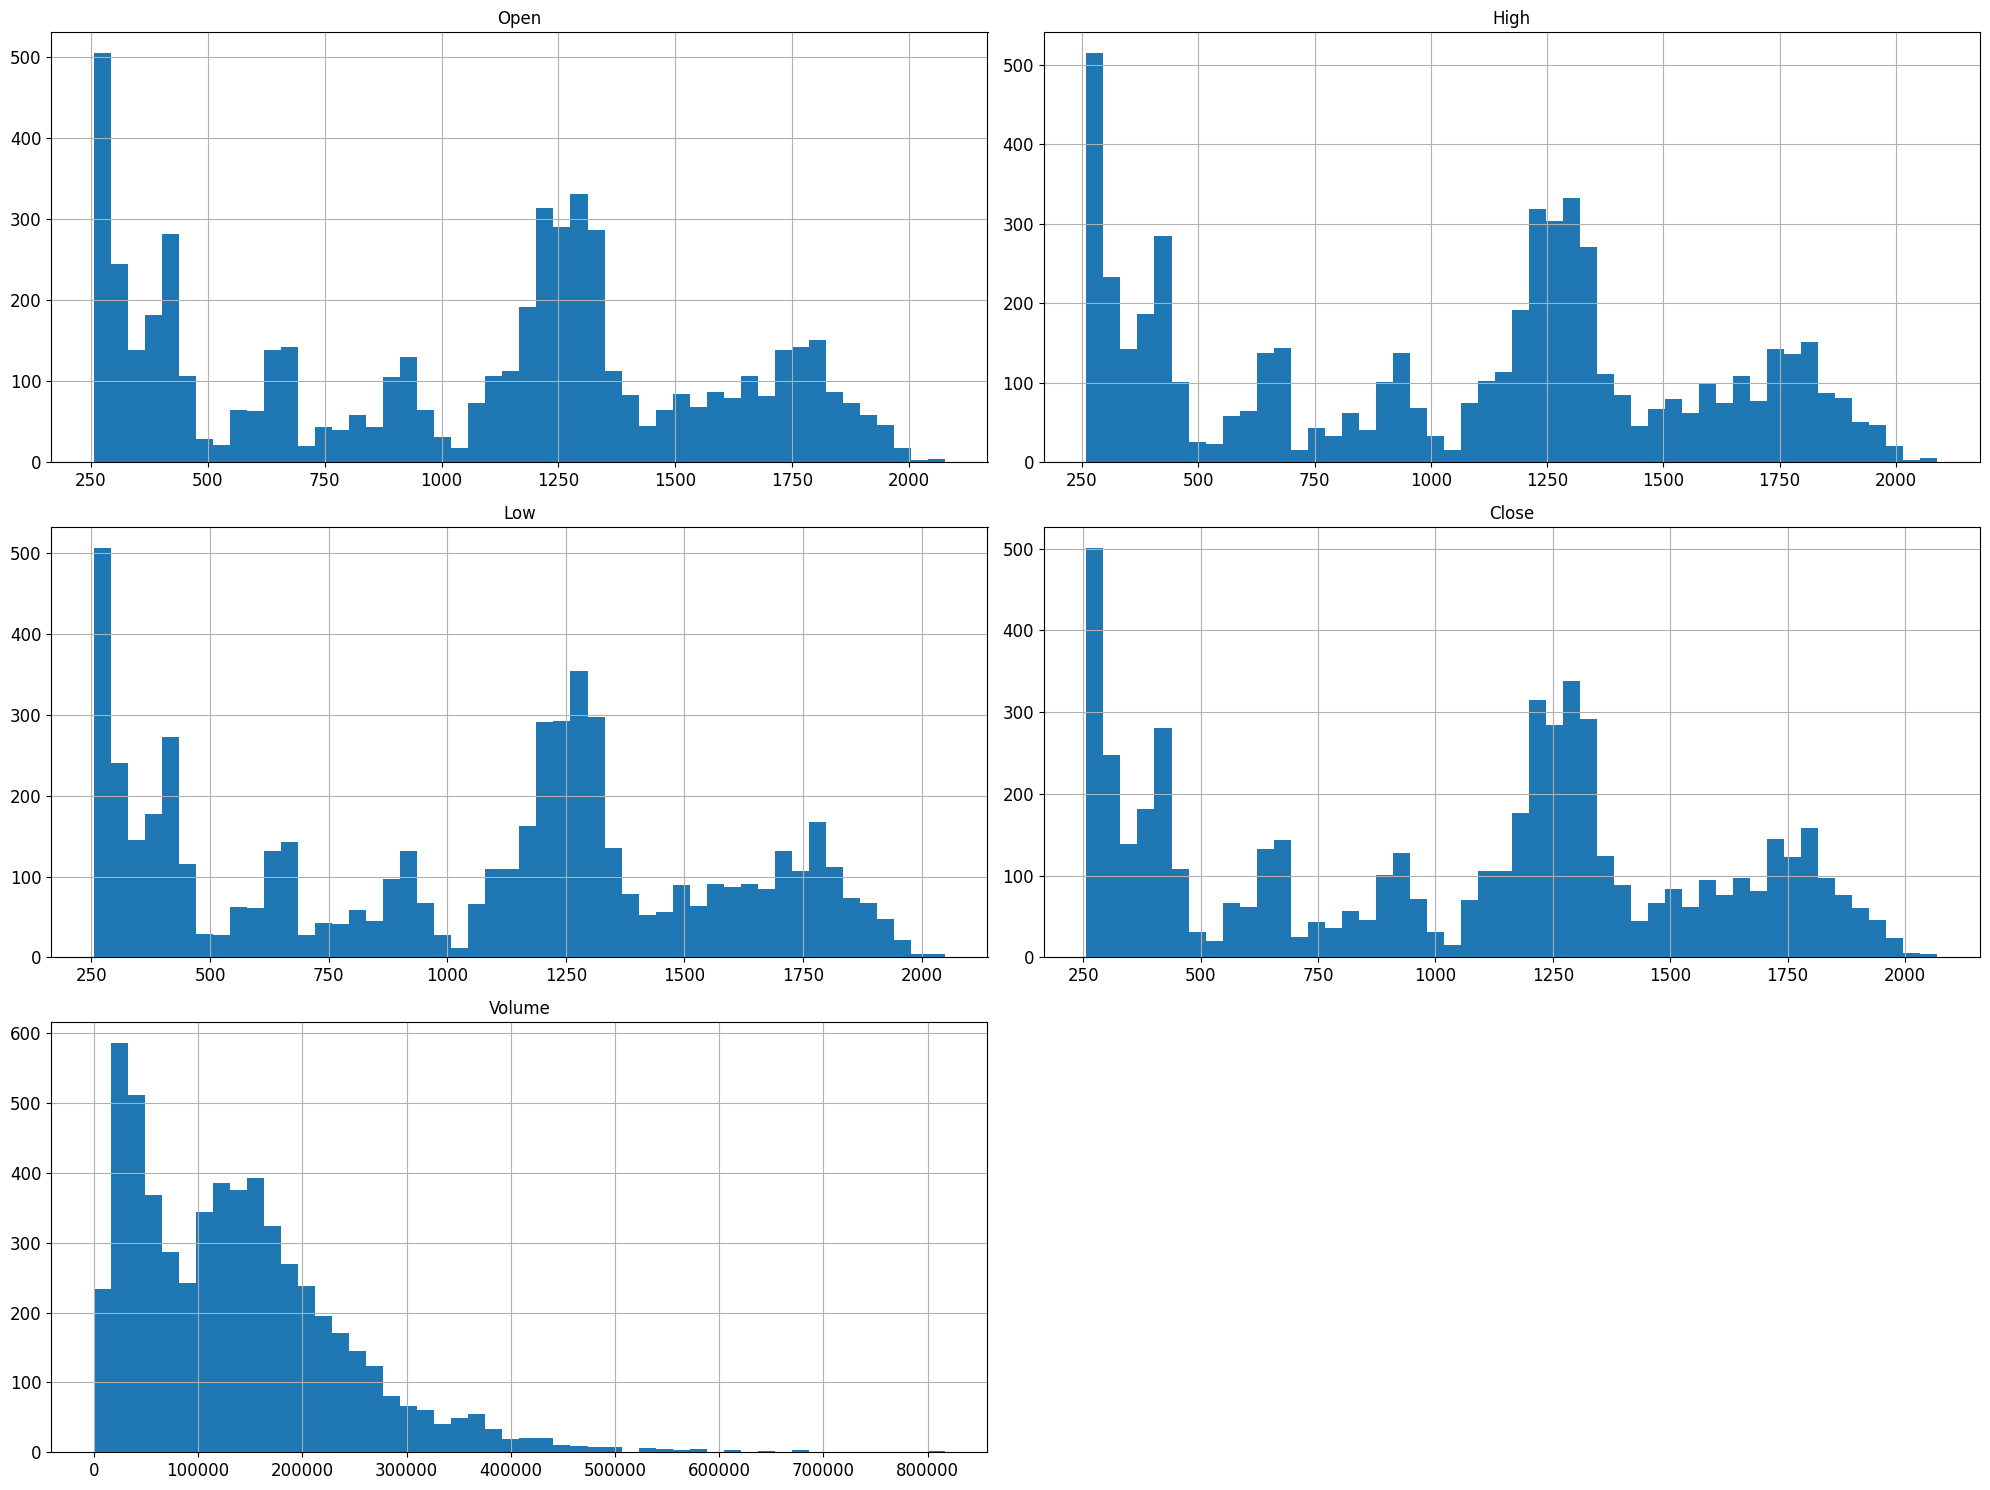

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
gold.hist(bins=50, figsize=(20,15))
plt.show()

## Create a Test Set

In [12]:
np.random.seed(42)

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(gold, 0.2)
len(train_set)

4563

In [14]:
len(test_set)

1140

In [15]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [16]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [17]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [19]:
gold["Open"].value_counts().head()

267.0     6
273.8     6
273.3     6
266.5     6
278.7     6
         ..
906.8     1
934.2     1
941.2     1
896.1     1
1707.9    1
Name: Open, Length: 4364, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(gold, test_size=0.2, random_state=42)

In [25]:
test_set.head()

,Open,Low,Close,Volume
1436,469.0,467.4,469.3,43497
748,346.0,343.6,351.6,37931
3463,1286.4,1259.6,1268.2,186264
1448,465.8,462.0,463.2,59338
4351,1280.0,1266.0,1277.5,302842


<AxesSubplot: >

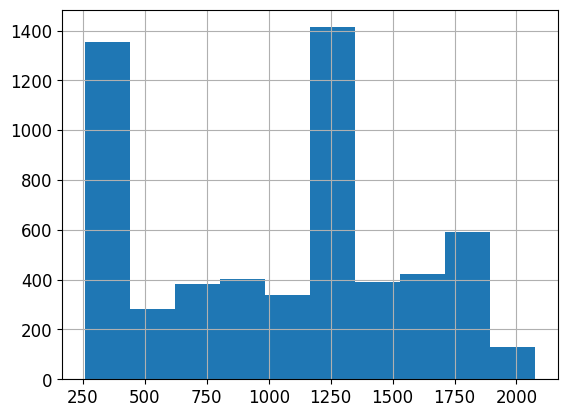

In [26]:
gold["Open"].hist()

In [28]:
gold["Low_ct"] = pd.cut(gold["Low"],
                               bins=[0, 15, 20, 25, 30, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [29]:
gold["Low_ct"].value_counts()

5    5703
1       0
2       0
3       0
4       0
Name: magnitude_cat, dtype: int64

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(gold, gold["Low_ct"]):
    strat_train_set = gold.loc[train_index]
    strat_test_set = gold.loc[test_index]

In [31]:
strat_test_set["Low_ct"].value_counts() / len(strat_test_set)

5    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: magnitude_cat, dtype: float64

In [32]:
gold["Low_ct"].value_counts() / len(gold)

5    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: magnitude_cat, dtype: float64

In [33]:
from sklearn.model_selection import train_test_split

def income_cat_proportions(data):
    return data["Low_ct"].value_counts() / len(data)

train_set, test_set = train_test_split(gold, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(gold),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [34]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.0,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,NaN,NaN
3,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,NaN,NaN
5,1.0,1.0,1.0,0.0,0.0


In [35]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Low_ct", axis=1, inplace=True)

In [36]:
gold.head()

,Open,Low,Close,Volume,magnitude_cat
0,289.5,280.0,283.7,21621,5
1,283.7,281.0,282.1,25448,5
2,281.6,280.2,282.4,19055,5
3,282.5,282.0,282.9,11266,5
4,282.4,281.8,282.7,30603,5


# Discover and Visualize the Data to Gain Insights

In [37]:
gold = strat_train_set.copy()

In [38]:
hazus = gold[gold["hazus_int"] == 1]
safe = gold[gold["hazus_int"] == 0]

plt.scatter(hazus["Val"], hazus["rel_vel"], alpha=0.2,
             s=hazus["ester_min"], label="hazus", c="red")

plt.scatter(safe["miss_dis"], safe["rel_vel"], alpha=0.2,
             s=safe["ester_min"], label="safe", c="blue")

plt.legend(loc='upper left')

KeyError: 'hazardous_int'

In [39]:
from pandas.plotting import scatter_matrix

attributes = ["ester_min", "rel_vel",
              "miss_dis", "abso_gnit", "hazus_int"]
scatter_matrix(gold[attributes], figsize=(16, 12))

KeyError: "None of [Index(['est_diameter_min', 'relative_velocity', 'miss_distance',\n       'absolute_magnitude', 'hazardous_int'],\n      dtype='object')] are in the [columns]"

In [40]:
gold.head()

,Open,Low,Close,Volume
960,380.0,379.1,382.7,38806
3707,1209.4,1205.0,1215.5,146536
1602,642.1,640.5,648.7,46662
4092,1257.2,1241.4,1248.3,155992
2692,1288.7,1287.5,1292.1,124135


## Looking for Correlations

In [41]:
corr_matrix = gold.corr()
corr_matrix["hazus_int"].sort_values(ascending=False)

KeyError: 'hazardous_int'

# Prepare the Data for Machine Learning Algorithms

In [42]:
gold = strat_train_set.drop("hazus_int", axis=1)
gold_labels = strat_train_set["hazus_int"].copy()

KeyError: "['hazardous_int'] not found in axis"

## Transformation Pipelines

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

full_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

gold_prepared = full_pipeline.fit_transform(gold)

In [44]:
gold_prepared

array([[-1.25260344, -1.24842443, -1.24778711, -0.96910208],
       [ 0.34664553,  0.35733017,  0.35878237,  0.09099358],
       [-0.74722225, -0.74019795, -0.73464171, -0.89179667],
       ...,
       [-1.42671989, -1.42437889, -1.42217937, -1.200359  ],
       [-0.73488177, -0.72794918, -0.73174804, -0.88304864],
       [ 1.51783414,  1.53262821,  1.51355242, -0.33298564]])

In [45]:
gold_prepared.shape

(4562, 4)

In [46]:
gold_prepared = full_pipeline.fit_transform(gold)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

kn_classifier = KNeighborsClassifier()
kn_classifier.fit(gold_prepared, gold_labels)

NameError: name 'neo_labels' is not defined

In [48]:
some_data = gold.iloc[:5]
some_labels = gold_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", kn_classifier.predict(some_data_prepared))

NameError: name 'neo_labels' is not defined

In [49]:
print("Labels:", list(some_labels))

NameError: name 'some_labels' is not defined

In [ ]:
some_data_prepared

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

gold_predictions = kn_classifier.predict(gold_prepared)
kn_mse = mean_squared_error(gold_labels, gold_predictions)
kn_rmse = np.sqrt(kn_mse)
print("KN RMSE: ", kn_rmse)
print("Classification report:\n", classification_report(gold_labels, gold_predictions))

In [ ]:
kn_accuracy = accuracy_score(gold_labels, gold_predictions)*100

print(f"Accuracy of KN Classifier = {kn_accuracy}")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(gold_prepared, gold_labels)

In [ ]:
gold_predictions = tree_classifier.predict(gold_prepared)

tree_mse = mean_squared_error(gold_labels, gold_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Tree RMSE: ", tree_rmse)
print("Confussion matrix:\n", confusion_matrix(gold_labels, gold_predictions), "\n")
print("Classification report:\n", classification_report(gold_labels, gold_predictions))

In [ ]:
tree_accuracy = accuracy_score(gold_labels, gold_predictions)*100

print(f"Accuracy of Decision Tree Classifier = {tree_accuracy}")

## Better Evaluation Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_classifier, gold_prepared, gold_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
kn_scores = cross_val_score(kn_classifier, gold_prepared, gold_labels,
                             scoring="neg_mean_squared_error", cv=10)
kn_rmse_scores = np.sqrt(-kn_scores)
display_scores(kn_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
forest_classifier.fit(gold_prepared, gold_labels)

In [ ]:
gold_predictions = forest_classifier.predict(gold_prepared)

forest_mse = mean_squared_error(gold_labels, gold_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Forest RMSE: ", forest_rmse)
print("Confussion matrix:\n", confusion_matrix(gold_labels, gold_predictions), "\n")
print("Classification report:\n", classification_report(gold_labels, gold_predictions))

In [ ]:
forest_accuracy = accuracy_score(gold_labels, gold_predictions)*100

print(f"Accuracy of Random Forest Classifier = {forest_accuracy}")

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_classifier, gold_prepared, gold_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(kn_classifier, gold_prepared, gold_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

# Fine-Tune Your Model

## Grid Search

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_classifier = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of 6*5=30 rounds of training 
grid_search = GridSearchCV(forest_classifier, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(gold_prepared, gold_labels)

NameError: name 'RandomForestClassifier' is not defined

In [51]:
grid_search.best_params_

NameError: name 'grid_search' is not defined

In [52]:
grid_search.best_estimator_

NameError: name 'grid_search' is not defined

In [53]:
pd.DataFrame(grid_search.cv_results_)

NameError: name 'grid_search' is not defined

## Randomized Search

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=10, high=200),
        'max_features': randint(low=1, high=5),
    }

forest_classifier = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_classifier, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(gold_prepared, gold_labels)

NameError: name 'RandomForestClassifier' is not defined

In [55]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

NameError: name 'rnd_search' is not defined

## Analyze the Best Models and Their Errors

In [56]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

NameError: name 'grid_search' is not defined

In [57]:
attributes = list(gold)
sorted(zip(feature_importances, attributes), reverse=True)

NameError: name 'feature_importances' is not defined

## Evaluate Your System on the Test Set

In [58]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("hazardous_int", axis=1)
y_test = strat_test_set["hazardous_int"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("Final RMSE: ", final_rmse)
print("Confussion matrix:\n", confusion_matrix(y_test, final_predictions), "\n")
print("Classification report:\n", classification_report(y_test, final_predictions))

NameError: name 'grid_search' is not defined

In [59]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

NameError: name 'final_predictions' is not defined

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)